<a href="https://colab.research.google.com/github/anagha1999/anlp-project/blob/main/tamil/3.Moral_Foundations_Tamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moral Foundations Analysis - Tamil Texts

This notebook analyzes Tamil classical texts (Thirukkural, Aathichoodi, etc.) for moral foundations using:
1. Master moral vectors (from 1.Generate_Tamil_MFD.ipynb)
2. Cleaned Tamil texts (from tamil-csv/)
3. Cosine similarity scoring
4. Two analysis methods: Average scores + Dominant distribution

Outputs:
- Detailed CSV files with verse-level moral scores
- PCA visualizations
- Distribution charts
- Summary statistics

## Load Tamil Master Moral Vectors

In [1]:
import pickle
import numpy as np
import pandas as pd
import os
from pathlib import Path

# Load Tamil master moral vectors
with open('tamil_master_moral_vectors.pkl', 'rb') as f:
    master_moral_vectors_tamil = pickle.load(f)

print("Master Moral Vectors loaded:")
for foundation, vector in master_moral_vectors_tamil.items():
    print(f"{foundation}: {vector[:5]}...")  # Print first 5 elements

Master Moral Vectors loaded:
care.virtue: [-0.01820922  0.01010052 -0.01616125 -0.00277066 -0.00108238]...
care.vice: [-0.01160204  0.00202883 -0.00275396  0.00212376 -0.00384181]...
fairness.virtue: [-0.01655583  0.00483554 -0.0107112  -0.00602367  0.00376076]...
fairness.vice: [ 0.00097255  0.00164303  0.00770801 -0.00599334 -0.00416056]...
loyalty.virtue: [-0.01360243  0.00682688 -0.00033667 -0.00468799  0.00723172]...
loyalty.vice: [-0.00057068 -0.0048489  -0.00019611 -0.00094322 -0.00780207]...
authority.virtue: [-0.01247829  0.01421615 -0.00244958 -0.00134895  0.00685352]...
authority.vice: [-0.00397229  0.00532196  0.00906202  0.00129553 -0.00250419]...
sanctity.virtue: [-0.01390889  0.01289998 -0.00074686 -0.00101416 -0.00827241]...
sanctity.vice: [-0.00581072  0.00650105  0.01670368 -0.00230699 -0.00139982]...


## Load and Embed Tamil Texts

In [2]:
from sentence_transformers import SentenceTransformer

EMBEDDINGS_MODEL_NAME = 'l3cube-pune/indic-sentence-similarity-sbert'
model = SentenceTransformer(EMBEDDINGS_MODEL_NAME)
print(f"✓ Model loaded: {EMBEDDINGS_MODEL_NAME}")

/Users/devisivakumar/MyWorkspace/ANLP_Project/anlp-project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Model loaded: l3cube-pune/indic-sentence-similarity-sbert


## Load Tamil Text Files and Generate Embeddings

We'll load all cleaned Tamil texts from the tamil-csv folder and generate embeddings for each verse/line.

In [3]:
# Find all CSV files in tamil-csv directory
data_dir = Path('./tamil-csv')
csv_files = list(data_dir.glob('*_cleaned.csv'))

print(f"Found {len(csv_files)} Tamil text files:")
for f in csv_files:
    print(f"  - {f.name}")

Found 7 Tamil text files:
  - aathichoodi_cleaned.csv
  - moothurai_cleaned.csv
  - nalvazhi_cleaned.csv
  - thirukkural_cleaned.csv
  - ulakaneethi_cleaned.csv
  - konraiventhan_cleaned.csv
  - vivekacinthamani_cleaned.csv


In [4]:
# Load texts and generate embeddings
file_embeddings = {}
file_texts = {}
file_dataframes = {}

for csv_file in csv_files:
    filename = csv_file.name
    print(f"\nProcessing: {filename}")
    
    # Load CSV
    df = pd.read_csv(csv_file, encoding='utf-8')
    file_dataframes[filename] = df
    
    # Determine text column (different files have different column names)
    if 'couplet' in df.columns:
        text_col = 'couplet'
    elif 'text' in df.columns:
        text_col = 'text'
    elif 'verse' in df.columns:
        text_col = 'verse'
    else:
        print(f"  Warning: No text column found in {filename}. Skipping.")
        continue
    
    # Extract texts
    texts = df[text_col].astype(str).tolist()
    file_texts[filename] = texts
    
    # Generate embeddings
    print(f"  Generating embeddings for {len(texts)} {text_col}s...")
    embeddings = model.encode(texts, show_progress_bar=True)
    file_embeddings[filename] = embeddings
    
    print(f"  ✓ Embeddings shape: {embeddings.shape}")

print(f"\nTotal files processed: {len(file_embeddings)}")


Processing: aathichoodi_cleaned.csv
  Generating embeddings for 111 texts...


Batches: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


  ✓ Embeddings shape: (111, 768)

Processing: moothurai_cleaned.csv
  Generating embeddings for 30 verses...


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


  ✓ Embeddings shape: (30, 768)

Processing: nalvazhi_cleaned.csv
  Generating embeddings for 40 verses...


Batches: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


  ✓ Embeddings shape: (40, 768)

Processing: thirukkural_cleaned.csv
  Generating embeddings for 1334 couplets...


Batches: 100%|██████████| 42/42 [00:03<00:00, 12.68it/s]


  ✓ Embeddings shape: (1334, 768)

Processing: ulakaneethi_cleaned.csv
  Generating embeddings for 13 verses...


Batches: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


  ✓ Embeddings shape: (13, 768)

Processing: konraiventhan_cleaned.csv
  Generating embeddings for 93 texts...


Batches: 100%|██████████| 3/3 [00:00<00:00, 14.27it/s]


  ✓ Embeddings shape: (93, 768)

Processing: vivekacinthamani_cleaned.csv
  Generating embeddings for 135 verses...


Batches: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]

  ✓ Embeddings shape: (135, 768)

Total files processed: 7


## Calculate Cosine Similarities

For each verse/line embedding, calculate its cosine similarity with each of the 10 master moral vectors.

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

print("Imported cosine_similarity from sklearn.metrics.pairwise.")

Imported cosine_similarity from sklearn.metrics.pairwise.


In [6]:
verse_moral_scores = {}

# Iterate through each file and its embeddings
for filename, embeddings_array in file_embeddings.items():
    print(f"\nCalculating moral scores for {filename}...")
    
    # Iterate through each verse embedding
    for i, verse_embedding in enumerate(embeddings_array):
        current_verse_scores = {}
        
        # Iterate through each master moral vector
        for foundation, master_vector in master_moral_vectors_tamil.items():
            # Reshape for cosine_similarity function
            verse_embedding_reshaped = verse_embedding.reshape(1, -1)
            master_vector_reshaped = master_vector.reshape(1, -1)
            
            # Calculate cosine similarity
            similarity = cosine_similarity(verse_embedding_reshaped, master_vector_reshaped)[0][0]
            current_verse_scores[foundation] = similarity
        
        # Store the scores for the current verse
        verse_moral_scores[(filename, i)] = current_verse_scores

print(f"\n✓ Calculated moral scores for {len(verse_moral_scores)} total verses.")
print("\nExample for the first verse:")
if verse_moral_scores:
    first_key = list(verse_moral_scores.keys())[0]
    print(f"  Key: {first_key}")
    print(f"  Scores: {verse_moral_scores[first_key]}")


Calculating moral scores for aathichoodi_cleaned.csv...

Calculating moral scores for moothurai_cleaned.csv...

Calculating moral scores for nalvazhi_cleaned.csv...

Calculating moral scores for thirukkural_cleaned.csv...

Calculating moral scores for ulakaneethi_cleaned.csv...

Calculating moral scores for konraiventhan_cleaned.csv...

Calculating moral scores for vivekacinthamani_cleaned.csv...

✓ Calculated moral scores for 1756 total verses.

Example for the first verse:
  Key: ('aathichoodi_cleaned.csv', 0)
  Scores: {'care.virtue': np.float32(0.1737765), 'care.vice': np.float32(0.12607582), 'fairness.virtue': np.float32(0.13728493), 'fairness.vice': np.float32(0.1574015), 'loyalty.virtue': np.float32(0.087733656), 'loyalty.vice': np.float32(0.12025784), 'authority.virtue': np.float32(0.20846045), 'authority.vice': np.float32(0.11790707), 'sanctity.virtue': np.float32(0.28047758), 'sanctity.vice': np.float32(0.13875952)}


## Prepare Data for PCA

Consolidate all verse embeddings and master moral vectors for dimensionality reduction.

In [7]:
# Consolidate all verse embeddings into a single NumPy array
all_verse_embeddings_list = []
for filename, embeddings_array in file_embeddings.items():
    if embeddings_array.size > 0:
        all_verse_embeddings_list.append(embeddings_array)

if all_verse_embeddings_list:
    all_verse_embeddings = np.vstack(all_verse_embeddings_list)
    print(f"Consolidated all verse embeddings. Total shape: {all_verse_embeddings.shape}")
else:
    all_verse_embeddings = np.array([])
    print("No verse embeddings found to consolidate.")

Consolidated all verse embeddings. Total shape: (1756, 768)


In [8]:
# Consolidate master moral vectors
master_moral_vectors_array = np.array(list(master_moral_vectors_tamil.values()))

print(f"Consolidated master moral vectors. Total shape: {master_moral_vectors_array.shape}")

Consolidated master moral vectors. Total shape: (10, 768)


In [9]:
from sklearn.decomposition import PCA

# Combine all embeddings for consistent PCA application
all_data = np.vstack((all_verse_embeddings, master_moral_vectors_array))

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(all_data)

# Separate the reduced data back
reduced_verse_embeddings = reduced_data[:len(all_verse_embeddings)]
reduced_master_moral_vectors = reduced_data[len(all_verse_embeddings):]

print(f"Reduced verse embeddings shape: {reduced_verse_embeddings.shape}")
print(f"Reduced master moral vectors shape: {reduced_master_moral_vectors.shape}")

Reduced verse embeddings shape: (1756, 2)
Reduced master moral vectors shape: (10, 2)


## Visualize Reduced Embeddings and Master Moral Vectors

✓ Saved PCA plot to ./tamil-step3-results/pca_visualization.png


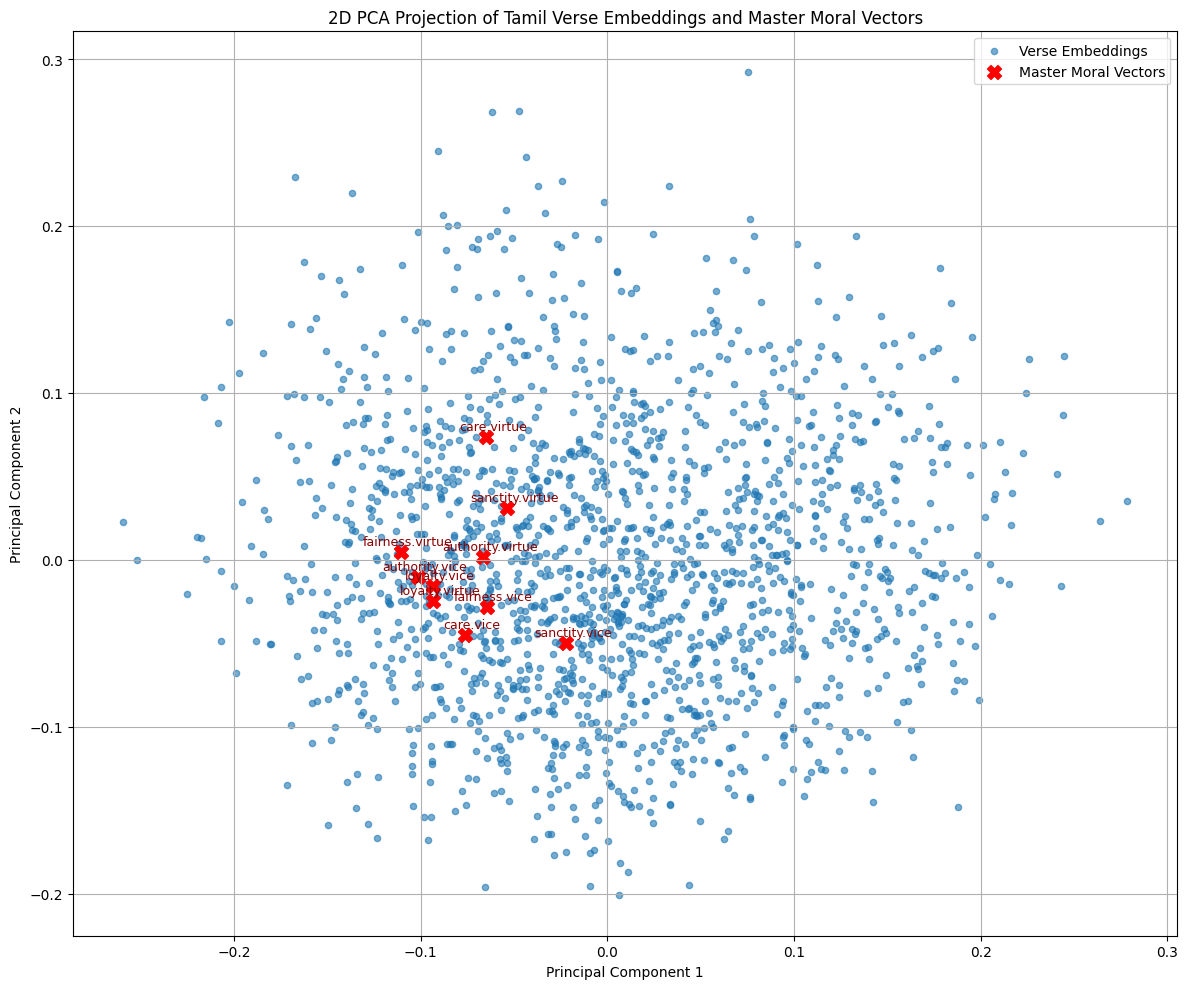

Generated PCA plot showing verse embeddings and master moral vectors.


In [10]:
import matplotlib.pyplot as plt

# Create output directory for visualizations
output_dir = './tamil-step3-results'
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(12, 10))

# Plot reduced verse embeddings
plt.scatter(
    reduced_verse_embeddings[:, 0],
    reduced_verse_embeddings[:, 1],
    alpha=0.6,
    label='Verse Embeddings',
    s=20
)

# Plot reduced master moral vectors
plt.scatter(
    reduced_master_moral_vectors[:, 0],
    reduced_master_moral_vectors[:, 1],
    color='red',
    s=100,
    marker='X',
    label='Master Moral Vectors'
)

# Annotate master moral vectors
for i, foundation_name in enumerate(master_moral_vectors_tamil.keys()):
    plt.annotate(
        foundation_name,
        (reduced_master_moral_vectors[i, 0], reduced_master_moral_vectors[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),
        ha='center',
        fontsize=9,
        color='darkred'
    )

plt.title('2D PCA Projection of Tamil Verse Embeddings and Master Moral Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
pca_plot_path = os.path.join(output_dir, 'pca_visualization.png')
plt.savefig(pca_plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved PCA plot to {pca_plot_path}")

plt.show()
print("Generated PCA plot showing verse embeddings and master moral vectors.")

# Method 1: Aggregate Moral Scores per Text (Average)

For each text file, consolidate the cosine similarity scores by averaging across all verses.

In [11]:
# Initialize dictionaries
aggregated_moral_scores = {}
verse_counts = {}

# Get all moral foundations
moral_foundations = list(master_moral_vectors_tamil.keys())

# Iterate through verse_moral_scores
for (filename, verse_index), current_verse_scores in verse_moral_scores.items():
    # Initialize entries if they don't exist
    if filename not in aggregated_moral_scores:
        aggregated_moral_scores[filename] = {foundation: 0.0 for foundation in moral_foundations}
        verse_counts[filename] = 0
    
    # Add current scores
    for foundation, score in current_verse_scores.items():
        aggregated_moral_scores[filename][foundation] += score
    
    # Increment count
    verse_counts[filename] += 1

# Calculate average scores
text_average_moral_scores = {}
for filename in aggregated_moral_scores:
    average_scores_for_text = {}
    for foundation in moral_foundations:
        if verse_counts[filename] > 0:
            average_scores_for_text[foundation] = aggregated_moral_scores[filename][foundation] / verse_counts[filename]
        else:
            average_scores_for_text[foundation] = 0.0
    text_average_moral_scores[filename] = average_scores_for_text

print(f"Aggregated moral scores for {len(text_average_moral_scores)} texts.")
print("\nExample for the first text:")
if text_average_moral_scores:
    first_filename = list(text_average_moral_scores.keys())[0]
    print(f"  Filename: {first_filename}")
    print(f"  Average Scores: {text_average_moral_scores[first_filename]}")

Aggregated moral scores for 7 texts.

Example for the first text:
  Filename: aathichoodi_cleaned.csv
  Average Scores: {'care.virtue': np.float32(0.42832124), 'care.vice': np.float32(0.3972957), 'fairness.virtue': np.float32(0.40720722), 'fairness.vice': np.float32(0.40267473), 'loyalty.virtue': np.float32(0.41135904), 'loyalty.vice': np.float32(0.39305434), 'authority.virtue': np.float32(0.4245132), 'authority.vice': np.float32(0.39646515), 'sanctity.virtue': np.float32(0.4520639), 'sanctity.vice': np.float32(0.43283084)}


In [12]:
# Save aggregated moral scores
output_dir = './tamil-step3-results'
os.makedirs(output_dir, exist_ok=True)

if text_average_moral_scores:
    print(f"Saving aggregated moral scores for {len(text_average_moral_scores)} texts...")
    for filename, scores in text_average_moral_scores.items():
        # Convert to DataFrame
        scores_df = pd.DataFrame(pd.Series(scores), columns=['average_score'])
        
        # Define output path
        output_filepath = os.path.join(output_dir, f"{filename.replace('.csv', '')}_moral_summary.csv")
        
        # Save to CSV
        scores_df.to_csv(output_filepath, index_label='Moral Foundation')
        print(f"  ✓ Saved {filename} moral summary to {output_filepath}")
else:
    print("Error: No aggregated scores to save.")

Saving aggregated moral scores for 7 texts...
  ✓ Saved aathichoodi_cleaned.csv moral summary to ./tamil-step3-results/aathichoodi_cleaned_moral_summary.csv
  ✓ Saved moothurai_cleaned.csv moral summary to ./tamil-step3-results/moothurai_cleaned_moral_summary.csv
  ✓ Saved nalvazhi_cleaned.csv moral summary to ./tamil-step3-results/nalvazhi_cleaned_moral_summary.csv
  ✓ Saved thirukkural_cleaned.csv moral summary to ./tamil-step3-results/thirukkural_cleaned_moral_summary.csv
  ✓ Saved ulakaneethi_cleaned.csv moral summary to ./tamil-step3-results/ulakaneethi_cleaned_moral_summary.csv
  ✓ Saved konraiventhan_cleaned.csv moral summary to ./tamil-step3-results/konraiventhan_cleaned_moral_summary.csv
  ✓ Saved vivekacinthamani_cleaned.csv moral summary to ./tamil-step3-results/vivekacinthamani_cleaned_moral_summary.csv


## Identify Most Prevalent Moral Foundation

For each text, determine the moral foundation with the highest average cosine similarity score.

In [13]:
most_prevalent_morals = {}

for filename, average_scores_for_text in text_average_moral_scores.items():
    if average_scores_for_text:
        max_foundation = max(average_scores_for_text, key=average_scores_for_text.get)
        max_score = average_scores_for_text[max_foundation]
        
        most_prevalent_morals[filename] = {
            'most_prevalent_foundation': max_foundation,
            'score': max_score
        }
    else:
        most_prevalent_morals[filename] = {
            'most_prevalent_foundation': 'None',
            'score': 0.0
        }

print("Most prevalent moral foundation for each text:")
for filename, data in most_prevalent_morals.items():
    print(f"  {filename}: {data['most_prevalent_foundation']} (score: {data['score']:.4f})")

Most prevalent moral foundation for each text:
  aathichoodi_cleaned.csv: sanctity.virtue (score: 0.4521)
  moothurai_cleaned.csv: sanctity.virtue (score: 0.5218)
  nalvazhi_cleaned.csv: sanctity.virtue (score: 0.5528)
  thirukkural_cleaned.csv: sanctity.vice (score: 0.5440)
  ulakaneethi_cleaned.csv: sanctity.virtue (score: 0.6258)
  konraiventhan_cleaned.csv: sanctity.virtue (score: 0.4133)
  vivekacinthamani_cleaned.csv: sanctity.virtue (score: 0.5195)


✓ Saved bar plot to ./tamil-step3-results/aathichoodi_cleaned_average_scores.png


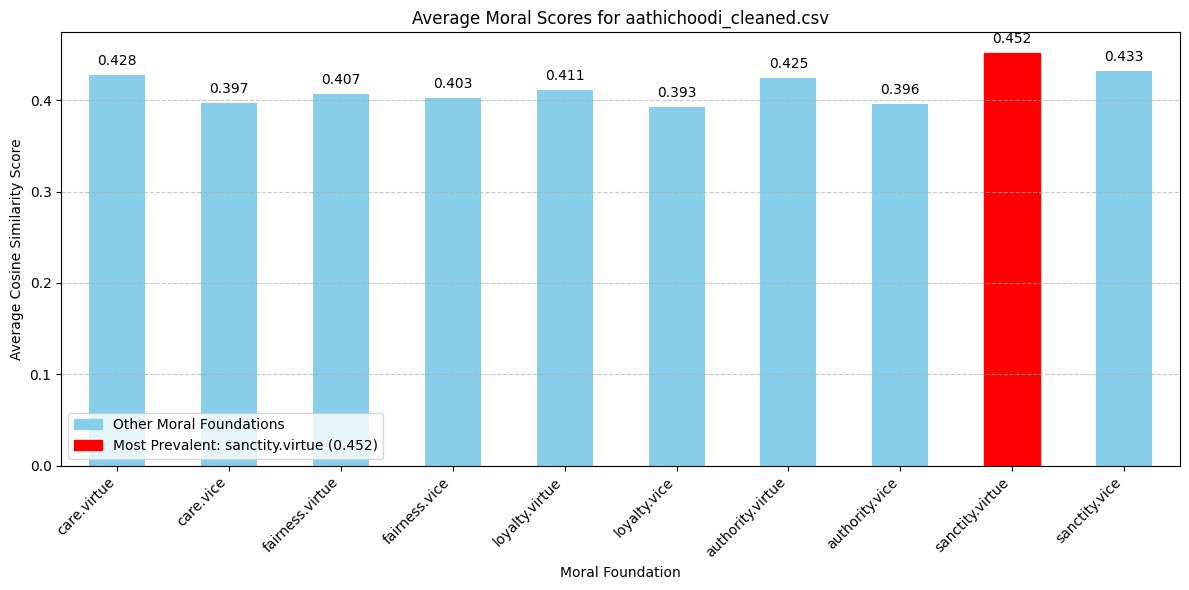

Generated bar plot for aathichoodi_cleaned.csv.
✓ Saved bar plot to ./tamil-step3-results/moothurai_cleaned_average_scores.png


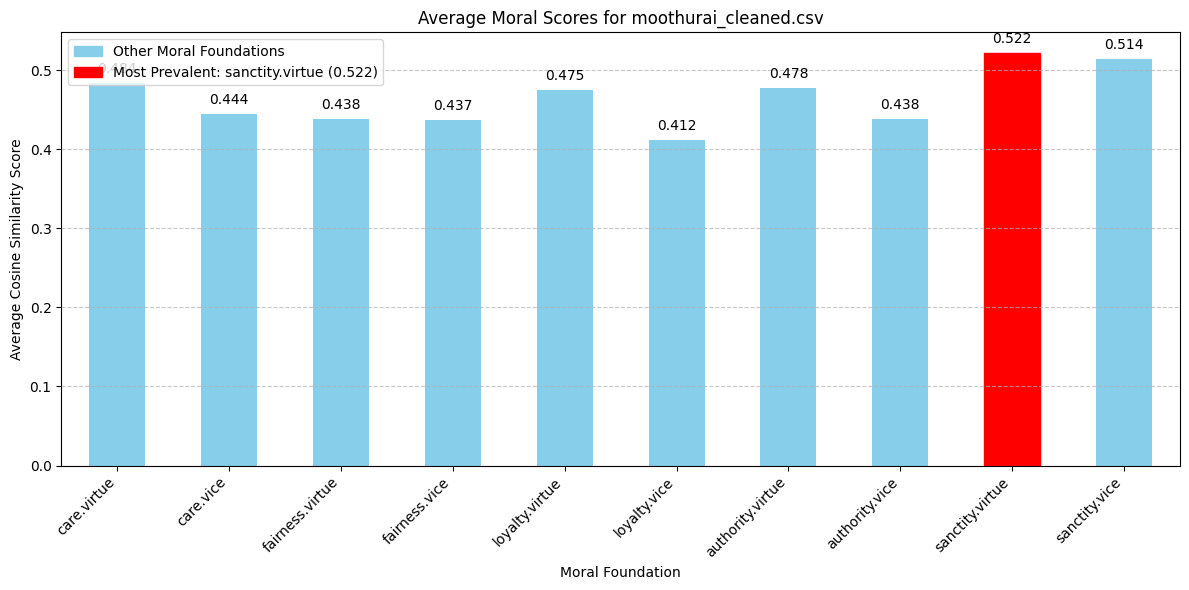

Generated bar plot for moothurai_cleaned.csv.
✓ Saved bar plot to ./tamil-step3-results/nalvazhi_cleaned_average_scores.png


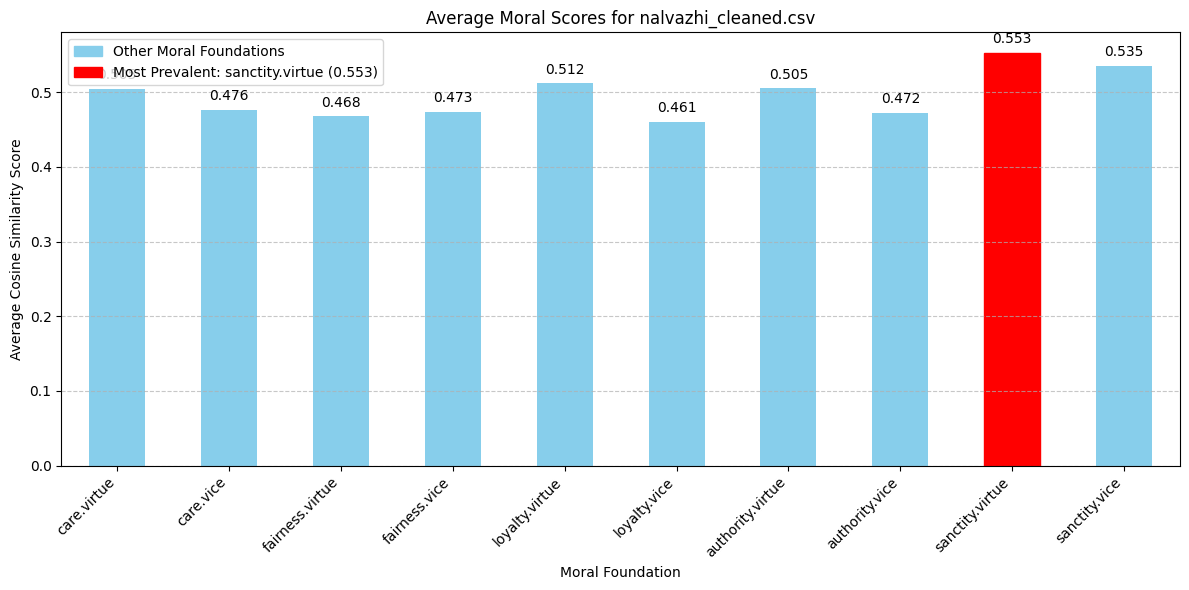

Generated bar plot for nalvazhi_cleaned.csv.
✓ Saved bar plot to ./tamil-step3-results/thirukkural_cleaned_average_scores.png


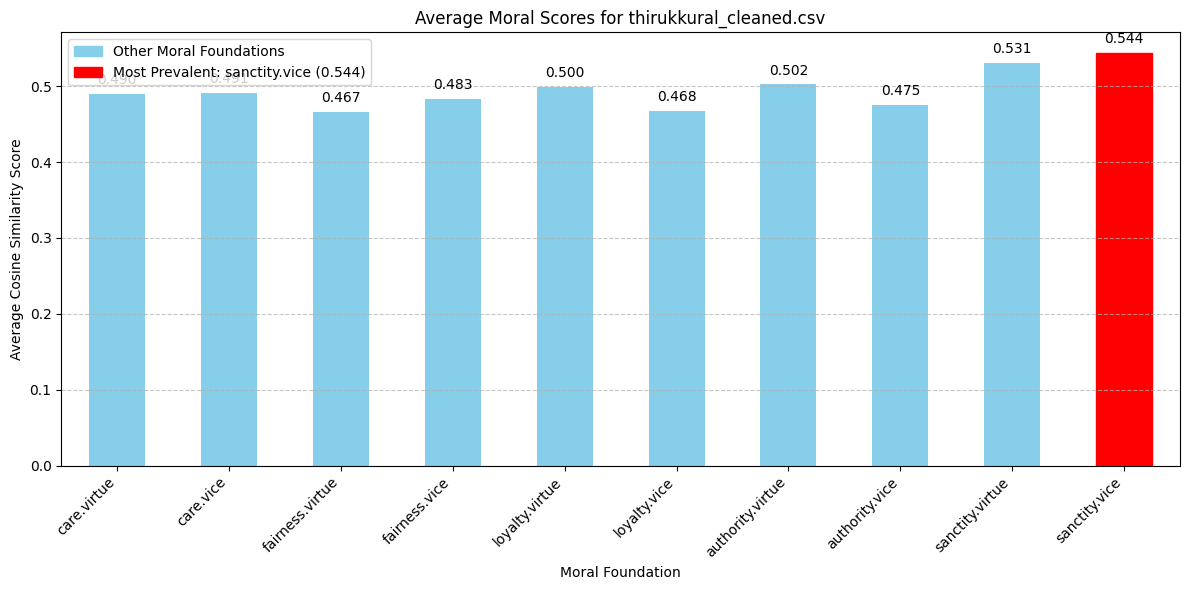

Generated bar plot for thirukkural_cleaned.csv.
✓ Saved bar plot to ./tamil-step3-results/ulakaneethi_cleaned_average_scores.png


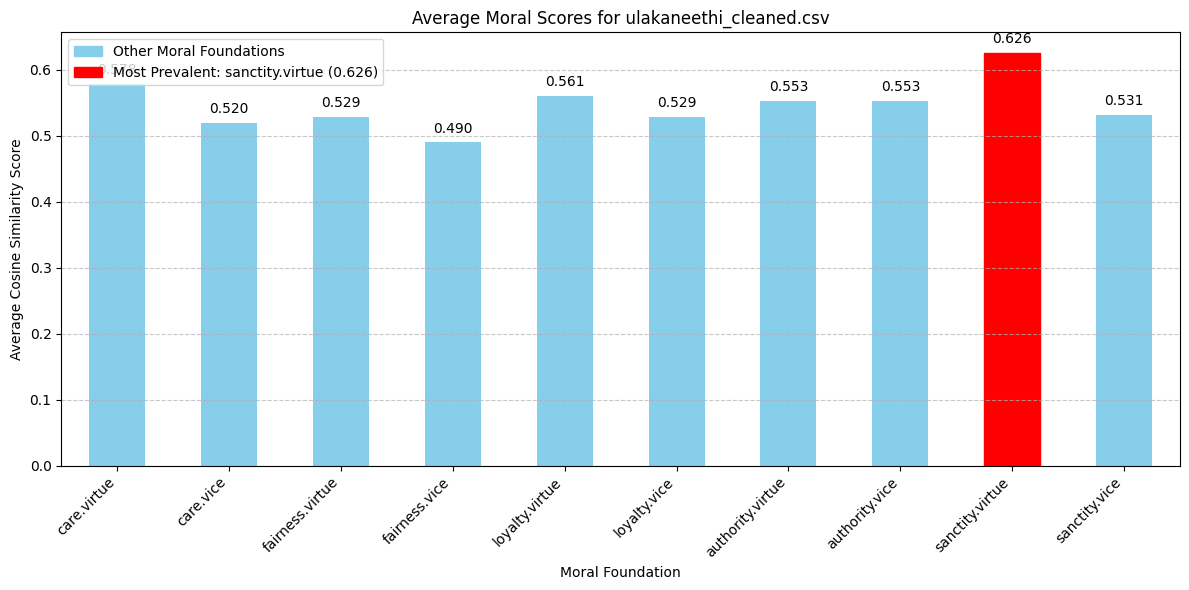

Generated bar plot for ulakaneethi_cleaned.csv.
✓ Saved bar plot to ./tamil-step3-results/konraiventhan_cleaned_average_scores.png


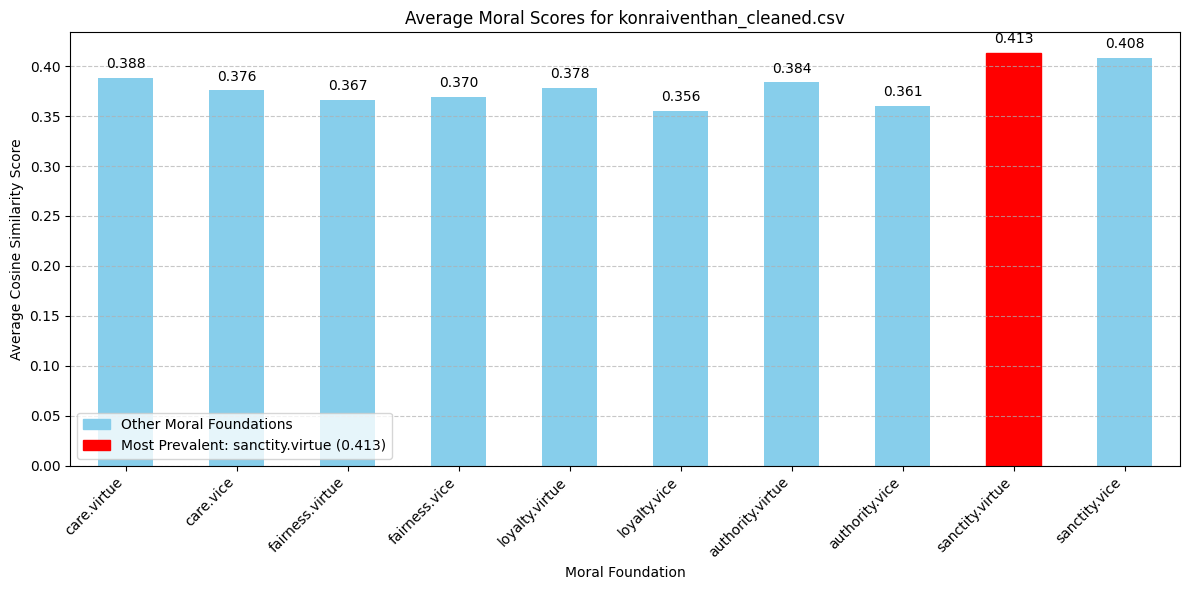

Generated bar plot for konraiventhan_cleaned.csv.
✓ Saved bar plot to ./tamil-step3-results/vivekacinthamani_cleaned_average_scores.png


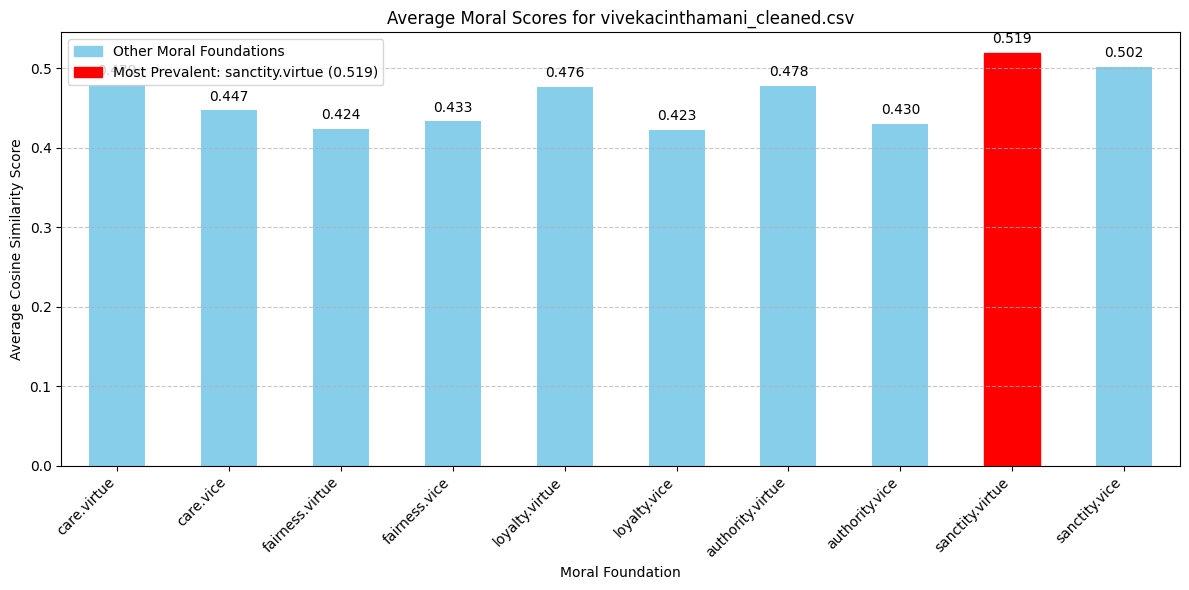

Generated bar plot for vivekacinthamani_cleaned.csv.


In [14]:
from matplotlib.patches import Patch

for filename, scores in text_average_moral_scores.items():
    scores_series = pd.Series(scores)
    
    plt.figure(figsize=(12, 6))
    ax = scores_series.plot(kind='bar', color='skyblue')
    
    # Identify most prevalent
    max_foundation = max(scores, key=scores.get)
    max_score = scores[max_foundation]
    
    # Change color of max bar
    for i, foundation_name in enumerate(scores_series.index):
        if foundation_name == max_foundation:
            ax.patches[i].set_color('red')
            break
    
    # Add values on bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')
    
    plt.title(f'Average Moral Scores for {filename}')
    plt.xlabel('Moral Foundation')
    plt.ylabel('Average Cosine Similarity Score')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Legend
    legend_handles = [
        Patch(color='skyblue', label='Other Moral Foundations'),
        Patch(color='red', label=f'Most Prevalent: {max_foundation} ({max_score:.3f})')
    ]
    plt.legend(handles=legend_handles)
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = filename.replace('.csv', '_average_scores.png')
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved bar plot to {plot_path}")
    
    plt.show()
    print(f"Generated bar plot for {filename}.")

# Method 2: Dominant Moral Distribution (Better Method)

**Note:** Cosine similarity doesn't capture variation/ranks well.
We will identify a "dominant" moral through distribution method.

## Identify Dominant Moral Foundation per Verse

For each verse, determine the moral foundation with the highest cosine similarity score.

In [15]:
dominant_moral_per_verse = {}

for (filename, verse_index), scores in verse_moral_scores.items():
    if scores:
        dominant_foundation = max(scores, key=scores.get)
        dominant_score = scores[dominant_foundation]
        
        dominant_moral_per_verse[(filename, verse_index)] = {
            'dominant_foundation': dominant_foundation,
            'score': dominant_score
        }
    else:
        dominant_moral_per_verse[(filename, verse_index)] = {
            'dominant_foundation': 'None',
            'score': 0.0
        }

print(f"Identified dominant moral foundation for {len(dominant_moral_per_verse)} verses.")
print("\nExample for the first verse:")
if dominant_moral_per_verse:
    first_key = list(dominant_moral_per_verse.keys())[0]
    print(f"  Key: {first_key}")
    print(f"  Dominant Foundation: {dominant_moral_per_verse[first_key]['dominant_foundation']}")
    print(f"  Score: {dominant_moral_per_verse[first_key]['score']:.4f}")

Identified dominant moral foundation for 1756 verses.

Example for the first verse:
  Key: ('aathichoodi_cleaned.csv', 0)
  Dominant Foundation: sanctity.virtue
  Score: 0.2805


## Export Verse-Level Moral Scores to CSV

Generate detailed CSV files containing verse-level information including verse number, text content, all moral foundation scores, dominant moral, and dominant score.

In [16]:
print("Generating verse-level CSV files for each text...")
print("=" * 80)

# Process each file
for filename in file_embeddings.keys():
    print(f"\nProcessing: {filename}")
    
    # Get original dataframe
    df = file_dataframes[filename]
    
    # Determine text column
    text_col = None
    for col in ['couplet', 'text', 'verse']:
        if col in df.columns:
            text_col = col
            break
    
    if text_col is None:
        print(f"  Warning: No text column found. Skipping.")
        continue
    
    # Collect data
    rows = []
    
    for (file, verse_idx), scores in verse_moral_scores.items():
        if file == filename:
            # Get verse text
            verse_text = df.iloc[verse_idx][text_col] if verse_idx < len(df) else ""
            
            # Get dominant moral info
            dominant_info = dominant_moral_per_verse.get((file, verse_idx), {})
            dominant_moral = dominant_info.get('dominant_foundation', 'None')
            dominant_score = dominant_info.get('score', 0.0)
            
            # Build row
            row = {
                'verse_number': verse_idx + 1,
                'text': verse_text
            }
            
            # Add all moral foundation scores
            for foundation in moral_foundations:
                row[foundation] = scores.get(foundation, 0.0)
            
            # Add dominant moral and score
            row['dominant_moral'] = dominant_moral
            row['dominant_score'] = dominant_score
            
            rows.append(row)
    
    # Create DataFrame
    if rows:
        df_output = pd.DataFrame(rows)
        df_output = df_output.sort_values('verse_number')
        
        # Save to CSV
        output_filename = filename.replace('.csv', '_moral_scores.csv')
        output_path = os.path.join(output_dir, output_filename)
        df_output.to_csv(output_path, index=False, encoding='utf-8')
        
        print(f"  ✓ Saved {len(rows)} verses to {output_path}")
        print(f"    Columns: {', '.join(df_output.columns)}")
    else:
        print(f"  ⚠ No data found for {filename}")

print("\n" + "=" * 80)
print(f"✓ CSV export complete! Files saved to {output_dir}/")

Generating verse-level CSV files for each text...

Processing: aathichoodi_cleaned.csv
  ✓ Saved 111 verses to ./tamil-step3-results/aathichoodi_cleaned_moral_scores.csv
    Columns: verse_number, text, care.virtue, care.vice, fairness.virtue, fairness.vice, loyalty.virtue, loyalty.vice, authority.virtue, authority.vice, sanctity.virtue, sanctity.vice, dominant_moral, dominant_score

Processing: moothurai_cleaned.csv
  ✓ Saved 30 verses to ./tamil-step3-results/moothurai_cleaned_moral_scores.csv
    Columns: verse_number, text, care.virtue, care.vice, fairness.virtue, fairness.vice, loyalty.virtue, loyalty.vice, authority.virtue, authority.vice, sanctity.virtue, sanctity.vice, dominant_moral, dominant_score

Processing: nalvazhi_cleaned.csv
  ✓ Saved 40 verses to ./tamil-step3-results/nalvazhi_cleaned_moral_scores.csv
    Columns: verse_number, text, care.virtue, care.vice, fairness.virtue, fairness.vice, loyalty.virtue, loyalty.vice, authority.virtue, authority.vice, sanctity.virtue, 

## Aggregate Dominant Morals per Text

Count the occurrences of each dominant moral foundation in each text's verses.

In [17]:
text_dominant_foundation_counts = {}

for (filename, verse_index), data in dominant_moral_per_verse.items():
    dominant_foundation = data['dominant_foundation']
    
    if filename not in text_dominant_foundation_counts:
        text_dominant_foundation_counts[filename] = {}
    
    text_dominant_foundation_counts[filename][dominant_foundation] = \
        text_dominant_foundation_counts[filename].get(dominant_foundation, 0) + 1

print(f"Aggregated dominant moral foundation counts for {len(text_dominant_foundation_counts)} texts.")
print("\nExample for the first text:")
if text_dominant_foundation_counts:
    first_filename = list(text_dominant_foundation_counts.keys())[0]
    print(f"  Filename: {first_filename}")
    print(f"  Dominant Foundation Counts: {text_dominant_foundation_counts[first_filename]}")

Aggregated dominant moral foundation counts for 7 texts.

Example for the first text:
  Filename: aathichoodi_cleaned.csv
  Dominant Foundation Counts: {'sanctity.virtue': 34, 'sanctity.vice': 30, 'fairness.vice': 4, 'authority.vice': 9, 'care.virtue': 15, 'authority.virtue': 6, 'loyalty.virtue': 7, 'care.vice': 1, 'fairness.virtue': 5}


## Normalize and Visualize Dominant Moral Distributions

Convert counts to proportions and generate visualizations.

In [18]:
text_dominant_foundation_proportions = {}

for filename, foundation_counts in text_dominant_foundation_counts.items():
    total_verses_in_text = verse_counts.get(filename, 0)
    
    if total_verses_in_text > 0:
        proportions = {
            foundation: count / total_verses_in_text
            for foundation, count in foundation_counts.items()
        }
        text_dominant_foundation_proportions[filename] = proportions
    else:
        text_dominant_foundation_proportions[filename] = {}

print("Calculated dominant moral foundation proportions for each text.")
for filename, proportions in text_dominant_foundation_proportions.items():
    print(f"\n  {filename}:")
    for foundation, prop in sorted(proportions.items(), key=lambda x: x[1], reverse=True):
        print(f"    {foundation}: {prop*100:.1f}%")

Calculated dominant moral foundation proportions for each text.

  aathichoodi_cleaned.csv:
    sanctity.virtue: 30.6%
    sanctity.vice: 27.0%
    care.virtue: 13.5%
    authority.vice: 8.1%
    loyalty.virtue: 6.3%
    authority.virtue: 5.4%
    fairness.virtue: 4.5%
    fairness.vice: 3.6%
    care.vice: 0.9%

  moothurai_cleaned.csv:
    sanctity.vice: 46.7%
    sanctity.virtue: 30.0%
    care.virtue: 13.3%
    authority.vice: 3.3%
    authority.virtue: 3.3%
    loyalty.virtue: 3.3%

  nalvazhi_cleaned.csv:
    sanctity.virtue: 47.5%
    sanctity.vice: 37.5%
    care.virtue: 5.0%
    loyalty.virtue: 5.0%
    authority.virtue: 2.5%
    authority.vice: 2.5%

  thirukkural_cleaned.csv:
    sanctity.vice: 47.7%
    sanctity.virtue: 19.7%
    care.virtue: 8.2%
    loyalty.virtue: 7.2%
    authority.virtue: 5.7%
    authority.vice: 4.0%
    care.vice: 2.7%
    fairness.vice: 2.5%
    fairness.virtue: 1.8%
    loyalty.vice: 0.4%

  ulakaneethi_cleaned.csv:
    sanctity.virtue: 92.3%
    c

✓ Saved distribution chart to ./tamil-step3-results/aathichoodi_cleaned_distribution.png


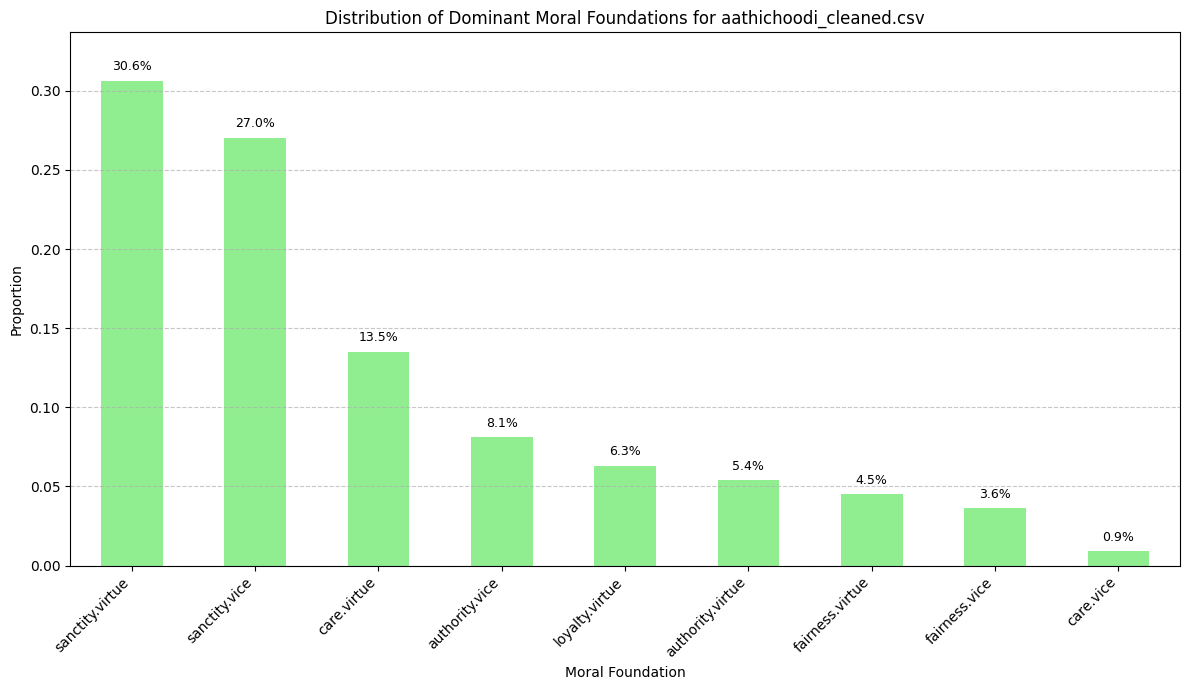

Generated distribution bar chart for aathichoodi_cleaned.csv.
✓ Saved distribution chart to ./tamil-step3-results/moothurai_cleaned_distribution.png


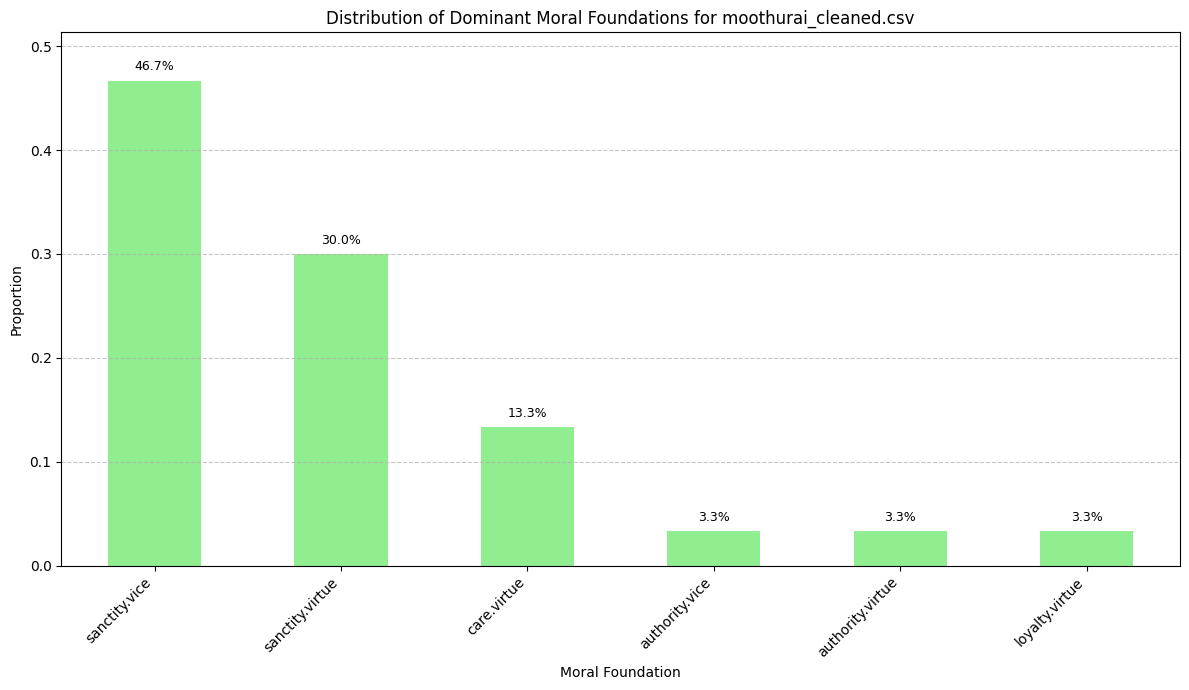

Generated distribution bar chart for moothurai_cleaned.csv.
✓ Saved distribution chart to ./tamil-step3-results/nalvazhi_cleaned_distribution.png


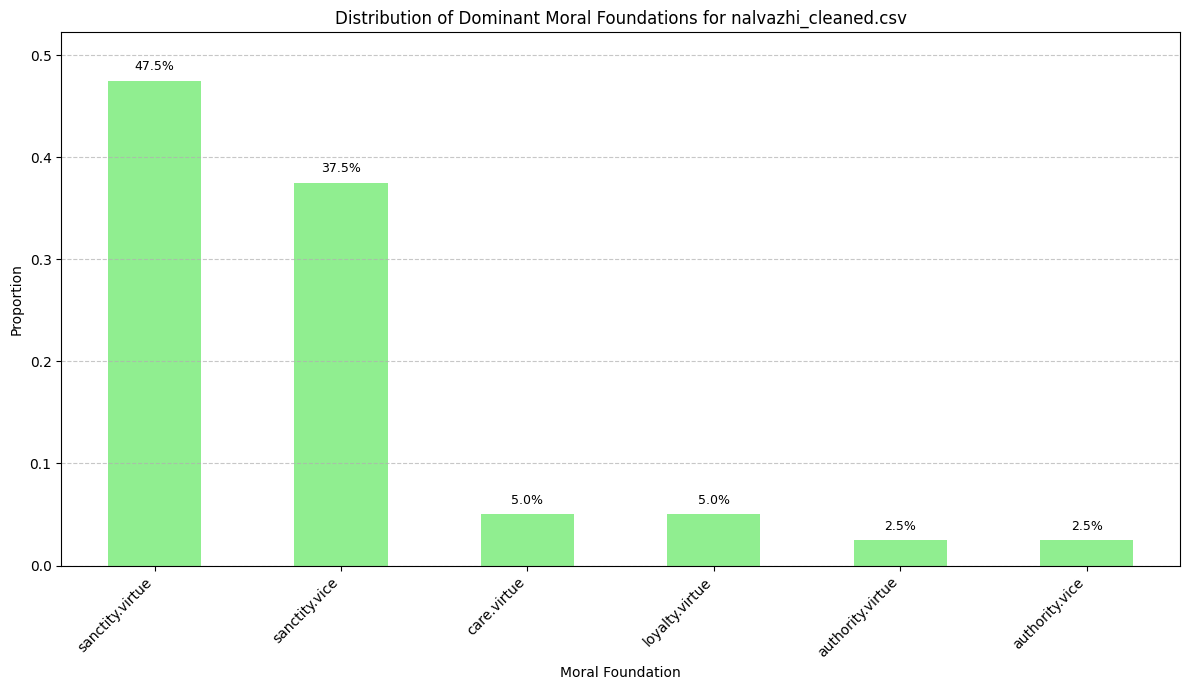

Generated distribution bar chart for nalvazhi_cleaned.csv.
✓ Saved distribution chart to ./tamil-step3-results/thirukkural_cleaned_distribution.png


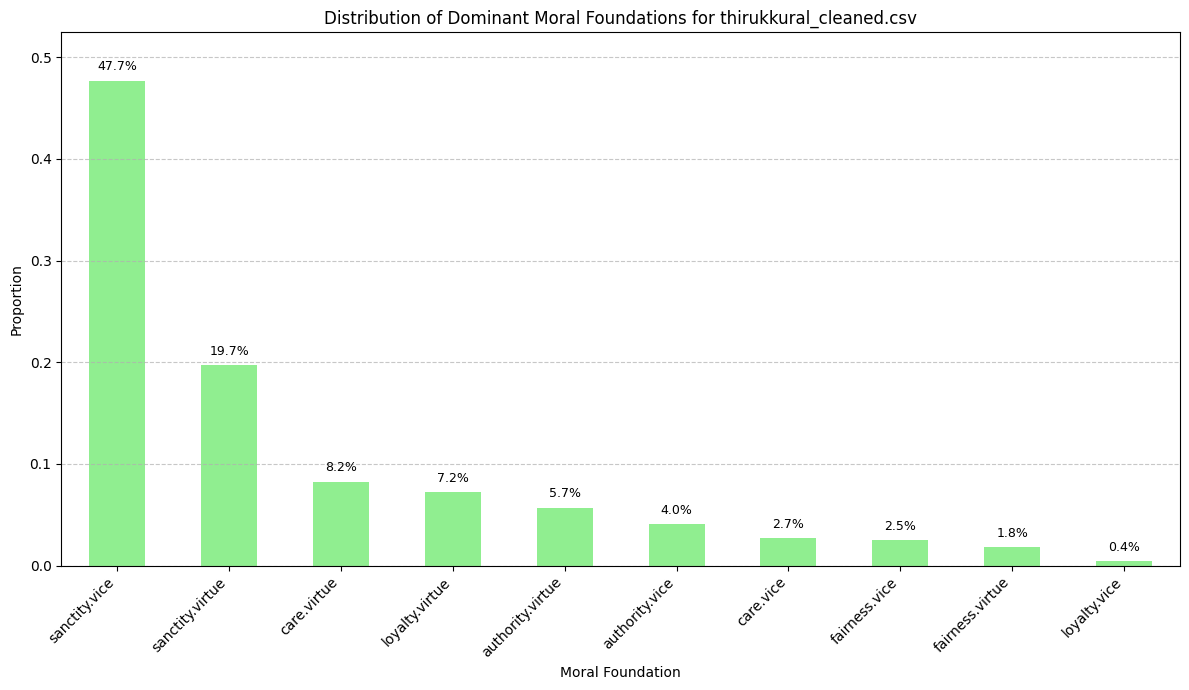

Generated distribution bar chart for thirukkural_cleaned.csv.
✓ Saved distribution chart to ./tamil-step3-results/ulakaneethi_cleaned_distribution.png


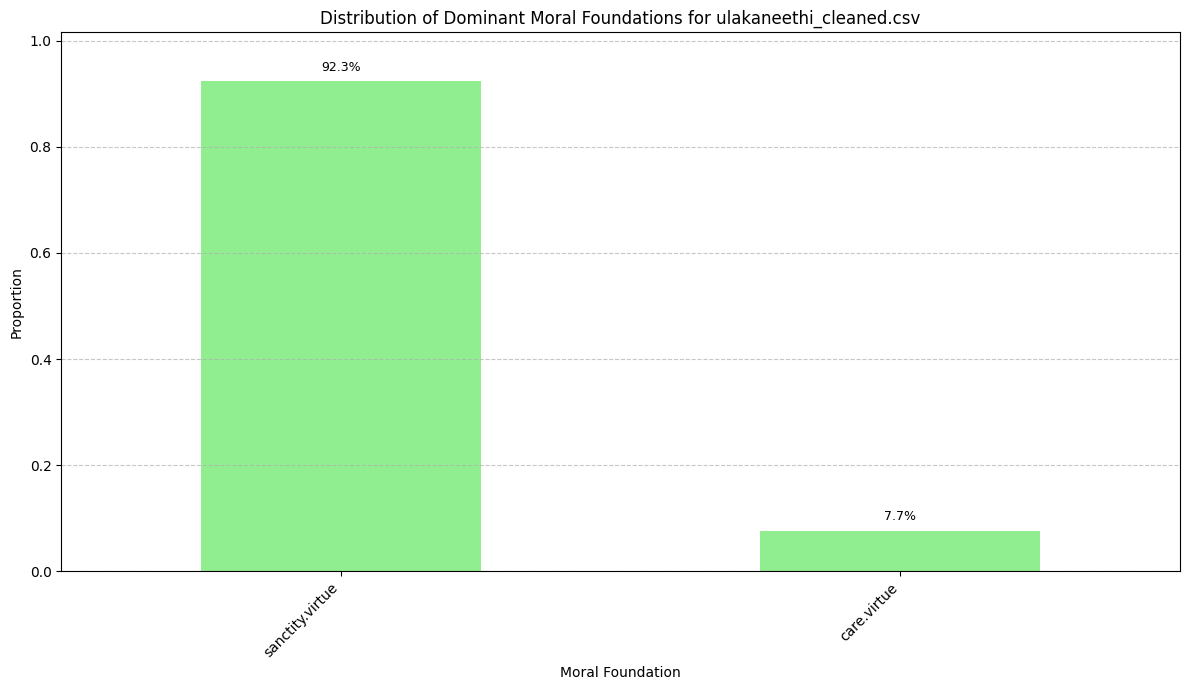

Generated distribution bar chart for ulakaneethi_cleaned.csv.
✓ Saved distribution chart to ./tamil-step3-results/konraiventhan_cleaned_distribution.png


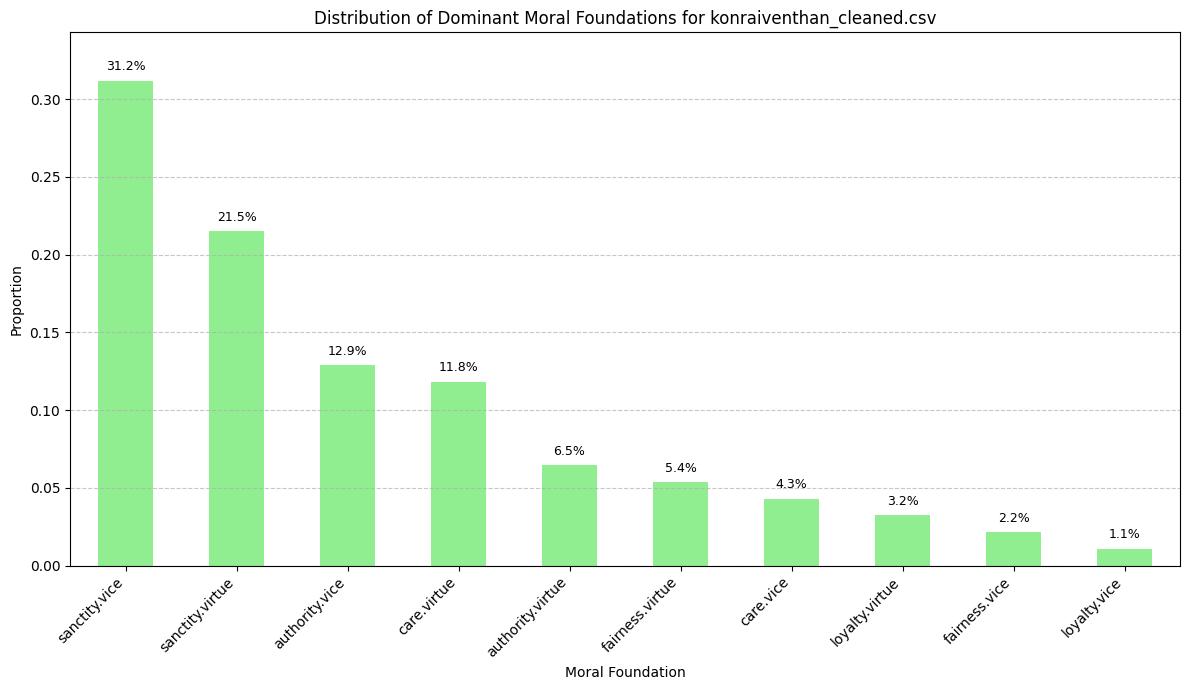

Generated distribution bar chart for konraiventhan_cleaned.csv.
✓ Saved distribution chart to ./tamil-step3-results/vivekacinthamani_cleaned_distribution.png


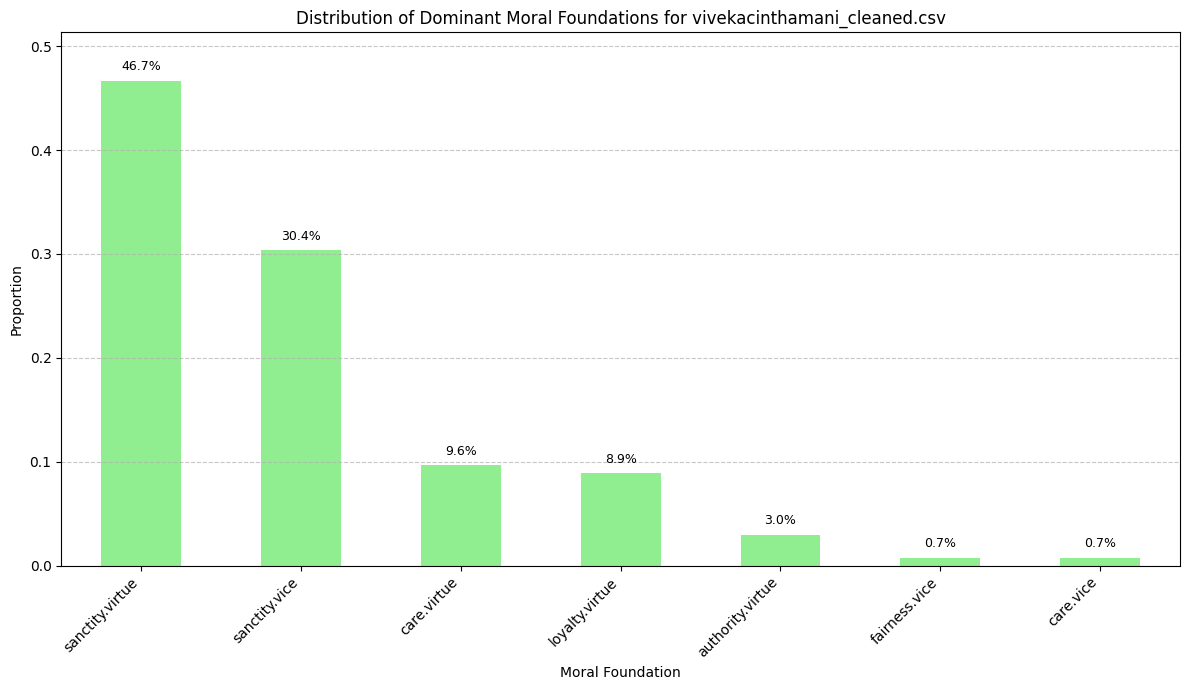

Generated distribution bar chart for vivekacinthamani_cleaned.csv.


In [19]:
for filename, proportions in text_dominant_foundation_proportions.items():
    if not proportions:
        print(f"No dominant moral foundations to visualize for {filename}.")
        continue
    
    proportions_series = pd.Series(proportions)
    proportions_series = proportions_series.sort_values(ascending=False)
    
    plt.figure(figsize=(12, 7))
    ax = proportions_series.plot(kind='bar', color='lightgreen')
    
    # Add percentage values on bars
    for p in ax.patches:
        percentage = f"{p.get_height() * 100:.1f}%"
        ax.annotate(percentage,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points',
                    fontsize=9)
    
    plt.title(f'Distribution of Dominant Moral Foundations for {filename}')
    plt.xlabel('Moral Foundation')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(proportions_series.values) * 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the plot
    plot_filename = filename.replace('.csv', '_distribution.png')
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved distribution chart to {plot_path}")
    
    plt.show()
    print(f"Generated distribution bar chart for {filename}.")

## Summary

### Data Analysis Key Findings:
* Calculated moral foundation scores for all Tamil verses using cosine similarity
* Applied two methods:
  - **Method 1 (Average)**: Averaged scores across verses per text
  - **Method 2 (Dominant Distribution)**: Counted dominant moral per verse and calculated proportions
* Generated PCA visualizations showing verse embeddings in relation to master moral vectors
* Exported detailed CSV files with verse-level moral scores
* Created distribution charts showing the breakdown of dominant morals

### Outputs:
* **Verse-level CSVs**: `{text_name}_moral_scores.csv` - Contains verse text, all 10 moral scores, dominant moral
* **Summary CSVs**: `{text_name}_moral_summary.csv` - Average scores per foundation
* **Visualizations**: PCA plots and distribution bar charts

### Next Steps:
* Compare moral profiles across different Tamil texts
* Analyze differences between classical wisdom texts (Thirukkural, Aathichoodi)
* Cross-language comparison with Kannada and English texts